In [1]:
from functions.load_all_data import load_data_by_color
from functions.crop_image import random_crop
from functions.torch_load_color import ColorDataSet
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split

In [2]:
# class ColorDataSet:
#     """
#     Data structure containing randomly cropped images
#     for training a neural network identifying the color
#     of an images.
#     """
    
#     def __init__(self, num_samples, crop_size=64):
#         self.samples = []
#         self.labels = []
    
#         default_imgs = load_data_by_color("Default")[0]
#         purple_imgs = load_data_by_color("Purple")[0]
#         gray_imgs = load_data_by_color("Gray-Scales")[0]
#         pink_imgs = load_data_by_color("Pink-Purple")[0]
        
#         # works similarly to training_samples function in load_training_data.py

#         for i in range(num_samples // 4):
#             def_index = np.random.randint(0, len(default_imgs))
#             default_img = default_imgs[def_index]
#             cropped_default_img = random_crop(default_img, crop_size=crop_size)[0]
#             self.samples.append(cropped_default_img)
#             self.labels.append(0.)
            
#             purp_index = np.random.randint(0, len(purple_imgs))
#             purple_img = purple_imgs[purp_index]
#             cropped_purple_img = random_crop(purple_img, crop_size=crop_size)[0]
#             self.samples.append(cropped_purple_img)
#             self.labels.append(1.)
            
#             gray_index = np.random.randint(0, len(gray_imgs))
#             gray_img = gray_imgs[gray_index]
#             cropped_gray_img = random_crop(gray_img, crop_size=crop_size)[0]
#             self.samples.append(cropped_gray_img)
#             self.labels.append(2.)
            
#             pink_index = np.random.randint(0, len(pink_imgs))
#             pink_img = pink_imgs[pink_index]
#             cropped_pink_img = random_crop(pink_img, crop_size=crop_size)[0]
#             self.samples.append(cropped_pink_img)
#             self.labels.append(3.)
            
#         self.ToTensor()
            
#     def __getitem__(self, idx):
#         # select one item from 
#         # potentially return dictionary with the 2 items
#         # see if this is necessary!
#         return self.samples[idx], self.labels[idx]
    
#     def __len__(self):
#         return len(self.samples)
    
#     def ToTensor(self):
#         """
#         swap color axis because
#         numpy image: H x W x C
#         torch image: C X H X W
#         """
#         for i in range(len(self.samples)):
#             self.samples[i] = self.samples[i].transpose((2,0,1))
#             self.samples[i] = torch.tensor(self.samples[i].astype(float) / 255.).type("torch.FloatTensor")
            
            
#         self.labels = torch.LongTensor(self.labels)

# Load training samples

In [3]:
torch.manual_seed(0) # set random seed for reproducable results
training_data = ColorDataSet(num_samples=4000)
split_data = random_split(training_data,[int(0.8*len(training_data)), 
                                         int(0.1*len(training_data)),
                                         int(0.1*len(training_data)),
                                         ])

In [4]:
print(split_data[0][0][0].shape)

torch.Size([3, 64, 64])


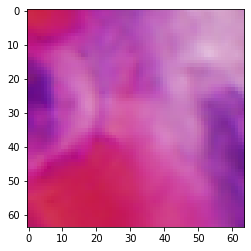

In [5]:
plt.imshow(np.moveaxis(split_data[0][2][0].numpy(), 0, -1))

In [6]:
train_set = DataLoader(split_data[0], batch_size=50)
validiation_set = DataLoader(split_data[1], batch_size=50)
test_set = DataLoader(split_data[2], batch_size=50)

# Configure GPU for training
* check for available GPUs using "watch nvidia-smi" in terminal

In [7]:
device=torch.device("cuda:7")

In [8]:
device.index

7

# Create Model
* This is the same model as the Keras implementation
* I moved this model to a pytorch lightning class in order to give it structure and aid readablibilty

In [9]:
from torch import nn
model = torch.nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3),
                                     stride=(2,2)),
                            nn.ReLU(),
                            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3,3),
                                     stride=(2,2)),
                            nn.ReLU(),
                            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(3,3),
                                      stride=(2,2)),
                            nn.ReLU(),
                            nn.Flatten(),
                            # calculate number of inputs / outputs to nn.linear
                            # input = size of Flatten layer = 392
                            # output = 256 (based on Keras model)
                            nn.Linear(392, 256),
                            nn.ReLU(),
                            nn.Linear(256, 4)
                           )

# Experiment with Pytorch Lightning
* Lightning structers PyTorch code so it can abstract the details of training
* TODO: add accuracy metrics

In [10]:
from torch import nn
from torch.nn import functional as F
import pytorch_lightning as pl
criterion = nn.CrossEntropyLoss()
class LightningColorClassifier(pl.LightningModule):
    
    def __init__(self):
        """
        This model is based off of the previously successful Keras model
        implemented using tensorflow. 
        """
        super(LightningColorClassifier, self).__init__()
        
        self.layer_1 = torch.nn.Sequential(nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3,3),
                                     stride=(2,2)),
                            nn.ReLU(),
                            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=(3,3),
                                     stride=(2,2)),
                            nn.ReLU(),
                            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(3,3),
                                      stride=(2,2)),
                            nn.ReLU(),
                            nn.Flatten(),
                            nn.Linear(392, 256),
                            nn.ReLU(),
                            nn.Linear(256, 4)
                           )
        self.train_acc = pl.metrics.Accuracy()
        self.valid_acc = pl.metrics.Accuracy()
        
    def forward(self, x):       
        return self.layer_1(x)
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(),lr=1e-3)
    
    def prepare_data(self):
        # use split data from above as a global var
        self.color_train, self.color_val = split_data[0], split_data[1]
    
    def cross_entropy_loss(self, logits, labels):
        return F.nll_loss(logits, labels)
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        logits = self(x)
        loss = criterion(logits, y)
        train_acc = self.train_acc(logits, y)
        
        self.log('train_loss',loss)
        self.log('train_acc_step', train_acc, on_step=True, on_epoch=True)
        return loss
    
    def training_epoch_end(self, outs):
        self.log('train_acc_epoch', self.train_acc.compute())
        
    def train_dataloader(self):
        return DataLoader(self.color_train, batch_size=64)
    
    def val_dataloader(self):
        return DataLoader(self.color_val, batch_size=64)
    
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        logits = self(x)
        loss = criterion(logits, y)
        val_acc = self.valid_acc(logits, y)
        
        self.log('val_loss',loss)
        self.log('valid_acc', val_acc, on_step=True, on_epoch=True)
        return loss
    
    def validation_end(self, outputs):
        avg_loss = nn.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss}
        return {'avg_val_loss':avg_loss, 'log':tensorboard_logs}

In [11]:
model = LightningColorClassifier()
from pytorch_lightning.callbacks import ModelCheckpoint
checkpoint_callback = ModelCheckpoint(
                    monitor='val_loss',
                    dirpath='checkpoints/',
                    filename='colorMod-{epoch:03d}-{val_loss:.2f}-{valid_acc:.2f}',
                    save_top_k=3,
                    mode='min')
trainer = pl.Trainer(gpus='7',
                    max_epochs=100,
                    default_root_dir='checkpoints/',checkpoint_callback=checkpoint_callback)
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name      | Type       | Params
-----------------------------------------
0 | layer_1   | Sequential | 113 K 
1 | train_acc | Accuracy   | 0     
2 | valid_acc | Accuracy   | 0     
/home/jupyter-ebueno@broadinstit-ee923/.local/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/home/jupyter-ebueno@broadinstit-ee923/.local/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


1

In [12]:
!ls checkpoints/

'colorMod-epoch=004-val_loss=0.09-valid_acc=0.94.ckpt'
'colorMod-epoch=006-val_loss=0.09-valid_acc=0.94.ckpt'
'colorMod-epoch=008-val_loss=0.06-valid_acc=0.94.ckpt'
 lightning_logs


In [16]:
net = LightningColorClassifier.load_from_checkpoint('checkpoints/colorMod-epoch=008-val_loss=0.06-valid_acc=0.94.ckpt')
net.to(device)

LightningColorClassifier(
  (layer_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(64, 16, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(16, 8, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
    (6): Flatten()
    (7): Linear(in_features=392, out_features=256, bias=True)
    (8): ReLU()
    (9): Linear(in_features=256, out_features=4, bias=True)
  )
  (train_acc): Accuracy()
  (valid_acc): Accuracy()
)

In [17]:
for inputs, labels in test_set:
    outputs = net(inputs.to(device))
    _, preds = torch.max(outputs,1)
    print(torch.sum(preds.cpu()==labels)/(len(labels)+0.))

tensor(1.)
tensor(0.9800)
tensor(0.9800)
tensor(1.)
tensor(1.)
tensor(0.9600)
tensor(1.)
tensor(1.)


In [15]:
# tensorboard --logdir checkpoints/lightning_logs/ --host dgx01.broadinstitute.org --port 6006